# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:

    gold_recovery_train.csv — обучающая выборка
    gold_recovery_test.csv — тестовая выборка 
    gold_recovery_full.csv — исходные данные 

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте их на корректность:


1. Подготовьте данные

1.1. Откройте файлы и изучите их.

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. 

1.3. Проанализируйте признаки, недоступные в тестовой выборке.

1.4. Проведите предобработку данных.

2. Проанализируйте данные

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. 

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

3. Постройте модель

3.1. Напишите функцию для вычисления итоговой sMAPE.

3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. 

Технологический процесс

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        Xanthate **— ксантогенат (промотер, или активатор флотации);
        Sulphate — сульфат (на данном производстве сульфид натрия);
        Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

Параметры этапов

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики Возможные значения для блока [тип_параметра]:
    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

Расчёт эффективности

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле
$$\begin{align} {Recovery} = \frac{C\times(F-T)}{F\times(C-T)}\times100\% \end{align}$$

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Метрика качества Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:
$$\begin{align} {sMAPE} = \frac{1}{N} \sum_{i=1}^{N}\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\times100\% \end{align}$$

Нужно спрогнозировать сразу две величины:

    эффективность обогащения чернового концентрата rougher.output.recovery;
    эффективность обогащения финального концентрата final.output.recovery.


# 1. Подготовка данных

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.dummy import DummyRegressor

SEED = 21

In [56]:
train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=['date'])
test = pd.read_csv('/datasets/gold_recovery_test.csv',index_col='date',parse_dates=['date'])
full = pd.read_csv('/datasets/gold_recovery_full.csv',index_col='date',parse_dates=['date'])

In [57]:
#посомтрим размеры выборок
train.shape, test.shape, full.shape

((16860, 86), (5856, 52), (22716, 86))

в тестовой выборке только 52 признака, а в исходных данных и обучающей 86 признаков

In [58]:
#Посмотрим признаки, недоступные в тестовой выборке, но которые есть в обучающей
diff_set = list(set(train.columns) - set(test.columns))
diff_set

['final.output.tail_sol',
 'final.output.concentrate_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.tail_pb',
 'rougher.output.concentrate_pb',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.output.recovery',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_sol',
 'final.output.tail_pb',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'final.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'final.output.tail_au',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'final.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_sol',
 'rougher.output.

Всего 34 признака

Признаки output отсутсвуют в тестовой выборке, но это целевые признаки.

Признаков calculation отсутсвуют в тестовой выборке для этапа rougher, скорее всего такие данные получаются непосредственно после самого процесса.

In [59]:
#посмотрим дубликаты
display(train.duplicated().sum())
display(test.duplicated().sum())
display(full.duplicated().sum())

16

6

22

In [60]:
#Посмотрим пропуски данных в тренировочной выборке
display(pd.concat([(train.isna() | train.isnull()).sum() / train.shape[0], (train.isna() | train.isnull()).sum()], axis=1,  keys=['%', 'кол-во']).sort_values('%', ascending=False).head(10))

,%,кол-во
rougher.output.recovery,0.152610,2573
rougher.output.tail_ag,0.133452,2250
rougher.output.tail_sol,0.133393,2249
rougher.output.tail_au,0.133393,2249
secondary_cleaner.output.tail_sol,0.117794,1986
rougher.input.floatbank11_xanthate,0.112930,1904
final.output.recovery,0.090214,1521
primary_cleaner.input.sulfate,0.077521,1307
primary_cleaner.input.depressant,0.074852,1262
rougher.calculation.au_pb_ratio,0.073665,1242


Пропусков в тренировочной выборке немало, большинство пропусков - целевые признаки output

2573 пропусков в rougher.output.recovery, что совпадает с количеством несовпавших расчетных значений

In [61]:
#Посмотрим пропуски данных в тестовой выборке
display(pd.concat([(test.isna() | test.isnull()).sum() / test.shape[0], (test.isna() | test.isnull()).sum()], axis=1,  keys=['%', 'кол-во']).sort_values('%', ascending=False).head(10))

,%,кол-во
rougher.input.floatbank11_xanthate,0.060280,353
primary_cleaner.input.sulfate,0.051571,302
primary_cleaner.input.depressant,0.048497,284
rougher.input.floatbank10_sulfate,0.043887,257
primary_cleaner.input.xanthate,0.028347,166
rougher.input.floatbank10_xanthate,0.021004,123
rougher.input.feed_sol,0.011441,67
rougher.input.floatbank11_sulfate,0.009392,55
rougher.input.feed_rate,0.006831,40
secondary_cleaner.state.floatbank3_a_air,0.005806,34


Пропуски в тестовой выборке незначительны

Обработку пропусков не будем делать, т.к. при обучении на кросс-валидации будем применять различные способы заполнения или удаления пропусков и проверим какой сработает лучше.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery.

In [62]:
#функция дя расчета обогащения
def recovery(conc, feed, tail):
    try:
        rec = (conc*(feed-tail)) / (feed*(conc-tail)) * 100
    except: 
        print('При расчете возникли ошибки (деление на нуль)')
    rec[rec<0] = np.nan
    rec[rec>100] = np.nan
    return rec

In [63]:
#Вычислим recovery из сырых значений и проверим кол-во совпадений с исходными
conc_au, feed_au, tail_au = train['rougher.output.concentrate_au'], train['rougher.input.feed_au'], train['rougher.output.tail_au']
rec_au = recovery(conc_au, feed_au, tail_au)

In [64]:
right_recovery_sum = np.isclose(train['rougher.output.recovery'], rec_au).sum()
right_recovery_sum, train.shape[0]-right_recovery_sum

(14287, 2573)

In [65]:
rec_au.describe()

count    14287.000000
mean        82.394201
std         15.096808
min         -0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
dtype: float64

In [66]:
rec_au.isna().sum()

2573

14287 рассчетных значений совпадает с иходными данными, а 2573 не совпадает, что сходится с количеством пропусков

In [67]:
#Найдем MAE между расчётами и значением признака, при расчете MAE заполним пропуски нулями
mean_absolute_error(train['rougher.output.recovery'].interpolate(method='time'),rec_au.interpolate(method='time'))

9.35113328539498e-15

MAE достаточно мала, recovery расчитан верно

Для подготовки данных к машинному обучению

    Удалим из train признаки которых нет в тесте
    Разделим данные не целевой признак и все остальные
    Так же разделим датасет на 2 части rougher и cleaner, так как процессы флотации и очистки не зависимы, то и предсказывать их тоже логично независимо.

Возможно предсказзывать recovery вообще не верный путь, так как он зависит от одного из обучающих параметров, может лучше для каждого процесса предсказыать output.concentrate и output.tail и затем на их основе уже считать recovery.

Проверим это на этапе машинного обучения, пока что просто запишем эти данные в отдельные переменные

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [68]:
process = ['rougher.input.feed','rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']
process_tail = ['rougher.input.feed','rougher.output.tail','primary_cleaner.output.tail','final.output.tail']
metals = ['au', 'ag', 'pb']

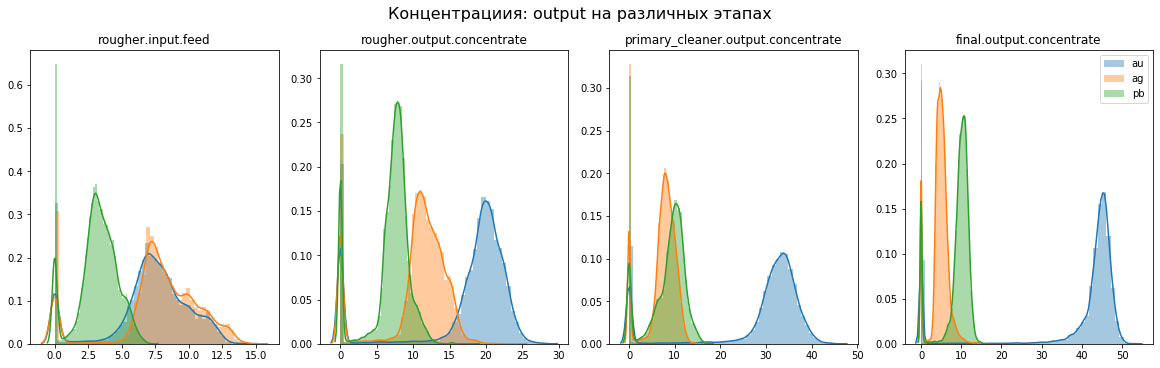

In [69]:
fig, axs = plt.subplots(1, len(process), figsize=(16, 5), constrained_layout=True)
fig.suptitle('Концентрациия: output на различных этапах', fontsize=16)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

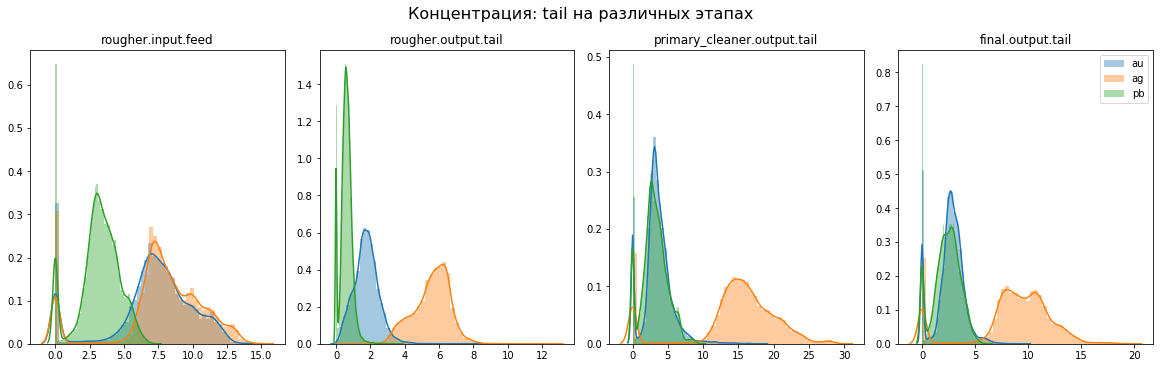

In [70]:
fig, axs = plt.subplots(1, len(process_tail), figsize=(16, 5), constrained_layout=True)
fig.suptitle('Концентрация: tail на различных этапах', fontsize=16)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

Концентрация золота растет по мере очистики, присутсвует значительное количетсво нулевых значений.

Концентрация металлов в хвостовых отвалах после различных этапов разная.

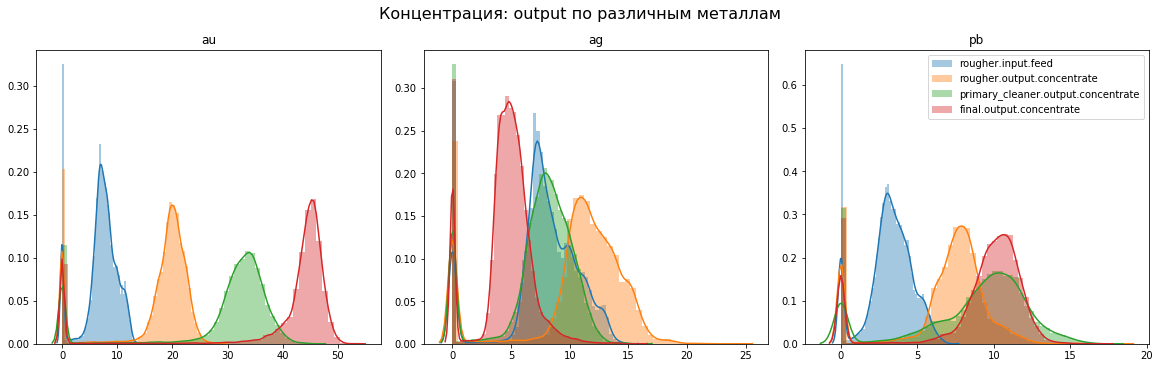

In [71]:
fig, axs = plt.subplots(1, len(metals), figsize=(16, 5), constrained_layout=True)
fig.suptitle('Концентрация: output по различным металлам', fontsize=16)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

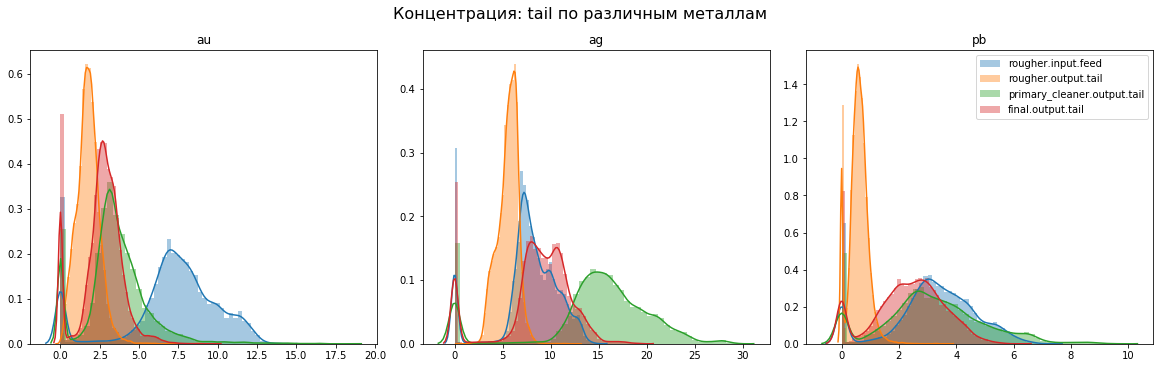

In [72]:
fig, axs = plt.subplots(1, len(metals), figsize=(16, 5), constrained_layout=True)
fig.suptitle('Концентрация: tail по различным металлам', fontsize=16)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

Концентрация золота значительно вырастает по мере очистки.

Концентрации серебра и свинца вырастают по мере очистки, но не так значительно.

Наибольшая концентрация металлов в хвостах после флотации.

Концентрация металлов при очиске в хвостах меньше.

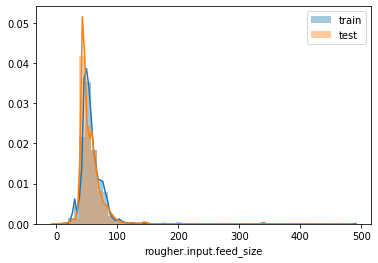

In [73]:
#Посмотрим распределения размеров гранул сырья на обучающей и тестовой выборках
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

Распределения несильно отличаются друг от друга, оценка модели будет правильной.

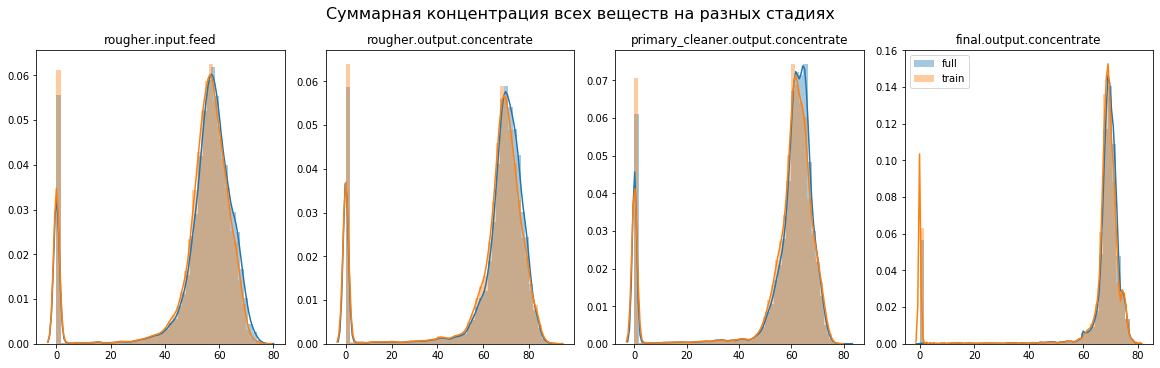

In [74]:
#Посмотрим суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
fig, axs = plt.subplots(1, len(process), figsize=(16, 5), constrained_layout=True)
fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=16)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_full = full[stage+ '_ag'] + full[stage+ '_au'] + full[stage+ '_pb'] + full[stage+ '_sol']
    sns.distplot(sum_full.dropna(), label='full', ax=ax)

    sum_train = train[stage+ '_ag'] + train[stage+ '_au'] + train[stage+ '_pb'] + train[stage+ '_sol']
    sns.distplot(sum_train.dropna(), label='train', ax=ax)
plt.legend()
plt.show()


Очень много нулевых значений в суммарном распределении, скорее всего это связано со сбоями измерительного оборудования.
Чтобы не искажать обучение моделей можно удалить их.

# 3. Модель

In [75]:
X_train = train[test.columns]

rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = test.loc[:, rougher_cols]
y_train_rougher = train[['rougher.output.tail_au', 'rougher.output.concentrate_au']]

final_cols = X_train.columns.str.contains('cleaner')
X_train_cleaner = X_train.loc[:, final_cols]
X_test_cleaner = test.loc[:, final_cols]
y_train_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

In [76]:
#функция расчета sMAPE с учетом двух и более столбцов
def sMAPE(y_true, y_pred, multioutput='uniform_average'):
    
    numerator = np.abs(y_true-y_pred)
    denominator =(np.abs(y_true)+np.abs(y_pred))/2
    
    output_errors = np.divide(numerator, denominator)
    
    nonzero_denominator = denominator != 0   
    output_errors[~nonzero_denominator] = 0
    
    output_scores = np.average(output_errors, axis=0)
    
    if multioutput == 'raw_values':
        return output_scores
    elif multioutput == 'uniform_average':
        pass
    return np.average(output_scores)

In [77]:
neg_smape = make_scorer(sMAPE, greater_is_better=False)

In [78]:
#подготовим пайплайн
pipe = Pipeline([('imp', SimpleImputer(missing_values=np.nan)),('scaler', StandardScaler()),('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])

In [79]:
#подготовим параметры для поиска по сетке
params = [
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=SEED)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [LinearRegression()]
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Ridge(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Lasso(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

In [80]:
#функция для заполнения пропущенных значений используем метод интерполяции, данные у нас отсортированы по времени и по ним видно, что соседние объекты в выборке схожи
def fill_target_nan(y):
    y = y.interpolate(method='time')
    return y

In [81]:
#функция для обработки нулевых значений в целевых признаках
def drop_target_zeros(X, y):
    y = y[(y != 0).all(1)]  
    X = X.loc[y.index, :]
    return X, y

In [82]:
#размеры выборок до обработки
X_train_rougher.shape, y_train_rougher.shape, X_train_cleaner.shape, y_train_cleaner.shape

((16860, 22), (16860, 2), (16860, 30), (16860, 2))

In [83]:
y_train_rougher = fill_target_nan(y_train_rougher)
y_train_cleaner = fill_target_nan(y_train_cleaner)
X_train_rougher, y_train_rougher = drop_target_zeros(X_train_rougher, y_train_rougher)
X_train_cleaner, y_train_cleaner = drop_target_zeros(X_train_cleaner, y_train_cleaner)        

In [84]:
#размеры выборок после обработки
X_train_rougher.shape, y_train_rougher.shape, X_train_cleaner.shape, y_train_cleaner.shape

((15313, 22), (15313, 2), (15038, 30), (15038, 2))

In [31]:
#поиск по сетке, поиск лучшей модели для флотации по метрике sMAPE
cv = TimeSeriesSplit(n_splits=3)
grid_rougher = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

In [32]:
grid_rougher.fit(X_train_rougher, y_train_rougher)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [33]:
grid_rougher.best_params_

{'imp__strategy': 'mean',
 'model': Lasso(alpha=0.021544346900318832, copy_X=True, fit_intercept=True,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=21, selection='cyclic', tol=0.0001, warm_start=False),
 'model__alpha': 0.021544346900318832}

In [34]:
grid_rougher.best_score_

-0.2837030162412595

In [35]:
#поиск по сетке, поиск лучшей модели для очистки по метрике sMAPE
grid_cleaner = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

In [36]:
grid_cleaner.fit(X_train_cleaner, y_train_cleaner)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.780756186679355, tolerance: 9.402729774037981
  positive)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [37]:
grid_cleaner.best_params_

{'imp__strategy': 'mean',
 'model': Lasso(alpha=1.2915496650148828, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=21,
       selection='cyclic', tol=0.0001, warm_start=False),
 'model__alpha': 1.2915496650148828}

In [38]:
grid_cleaner.best_score_

-0.17534833465197444

In [85]:
#Смотрим пайплайн с лушими параметрами по всем данным, получаем предсказания для теста выходной и хвостовой концентраций
input_au = test['rougher.input.feed_au'].fillna(0)
pipe_rougher = grid_rougher.best_estimator_
if type(pipe_rougher.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_rougher.steps[2][1].n_estimators = 100
pipe_rougher.fit(X_train_rougher, y_train_rougher)
y_pred_rougher_tail, y_pred_rougher_conc = pipe_rougher.predict(X_test_rougher).T
rougher_recovery = recovery(y_pred_rougher_conc, input_au, y_pred_rougher_tail)

In [86]:
#прогноз эффективности обогащения чернового концентрата rougher.output.recovery
smape_rougher = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(method='time'), rougher_recovery.interpolate(method='time'))
smape_rougher

0.10257891008840601

In [87]:
pipe_cleaner = grid_cleaner.best_estimator_
if type(pipe_cleaner.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_cleaner.steps[2][1].n_estimators = 100 
pipe_cleaner.fit(X_train_cleaner, y_train_cleaner)
y_pred_cleaner_tail, y_pred_cleaner_conc = pipe_cleaner.predict(X_test_cleaner).T
cleaner_recovery = recovery(y_pred_cleaner_conc, input_au, y_pred_cleaner_tail)

In [88]:
#прогноз эффективности обогащения финального концентрата final.output.recovery
smape_cleaner = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0), cleaner_recovery.fillna(0))
smape_cleaner

0.1348133876901321

In [91]:
#итоговая метрика sMAPE
final_smape = 0.25*smape_rougher + 0.75*smape_cleaner
final_smape

0.1267547682897006

In [106]:
#Воспользуется предсказанием в виде медианы, чтобы сделаем проверку на адекватность, сравним относительную оценку лучшей модели от предсказания медиане
smape_rougher_median = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(method='time'), rougher_recovery.interpolate(method='time').median())
smape_cleaner_median = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0), cleaner_recovery.fillna(0).median())
final_smape_median = 0.25*smape_rougher_median + 0.75*smape_cleaner_median
final_smape_median

0.21601751538101627

Модель прошла проверку на адекватность. Обученная модель предсказывает результат точнее константной.

## Выводы

Загружены и первично изучены данные.

Проверен расчет эффективности обогащения. MAE между данной и вычисленной обучающей выборке для признака rougher.output.recovery равно нулю;

Проанализировали признаки, недоступные в тестовой выборке. В тестовой выборке остутствуют параметры, которые можно узнать только после прохождения всех стадий производства:

Изучено изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Концентрация золота планомерно растет. Концентрация серебра в финальном концентрате ниже, чем в сырье. Доля свинца вырастает после первичной очистки, но потом не изменяется.

Проведено сравнение распределения размеров гранул сырья на обучающей и тестовой выборках - распределения схожи.

Исследованы суммарные концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Суммарная концентраци немного растет после первичной обработки сырья.

Подготовлены данные для прогнозирования.Проведено предварительное обучение моделей. Подобраны Гиперпараметры модели.
Найлушей моделью оказался - Lasso.

Произведена провекра модели на адекватность. Обученная модель предсказывает результат точнее медианной.